In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [4]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### **_EDA  (Exporatory data analysis)_**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
print('Data shape before dropping columns with missing data : {}'.format(df.shape))

df.drop(['alley','miscfeature','fence','fireplacequ', 'poolqc'], axis = 1, inplace = True)

print('Data shape after dropping columns : {}'.format(df.shape))

Data shape before dropping columns with missing data : (1460, 81)
Data shape after dropping columns : (1460, 76)


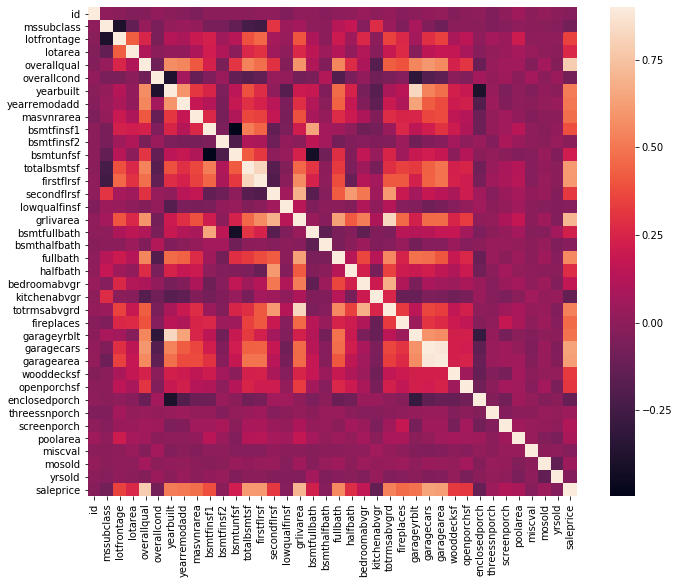

In [7]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

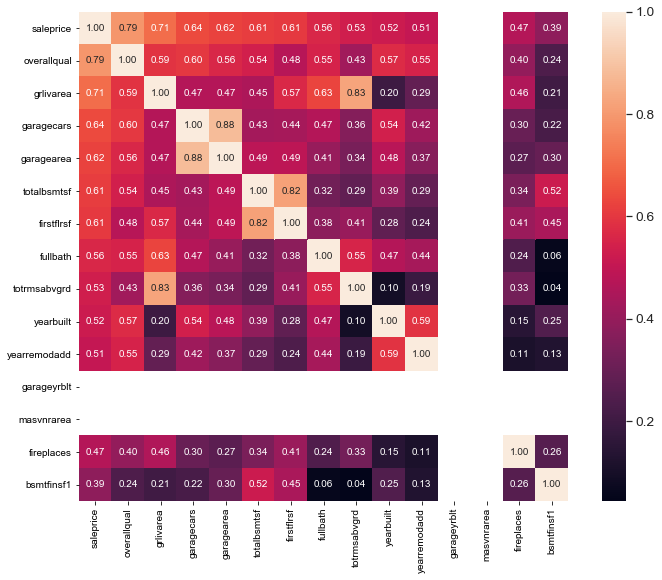

In [8]:
'''Lets look at the correlated features'''
k = 15
corrmat = df.corr()
cols = corrmat.nlargest(k, 'saleprice')['saleprice'].index
cm = np.corrcoef(df[cols].values.T)
plt.subplots(figsize=(12,9))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**_our target Sale price seems to be highly correlated with the feature in the heatmap above_**

**_Let's take a look at Null/NaN values in our data_**

In [9]:
missing_values = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([missing_values, percent_missing], axis = 1, keys = ['Total','percent'])[:20]
missing.head(8)

,Total,percent
lotfrontage,259,0.177397
garagefinish,81,0.055479
garagetype,81,0.055479
garagecond,81,0.055479
garagequal,81,0.055479
garageyrblt,81,0.055479
bsmtexposure,38,0.026027
bsmtfintype2,38,0.026027


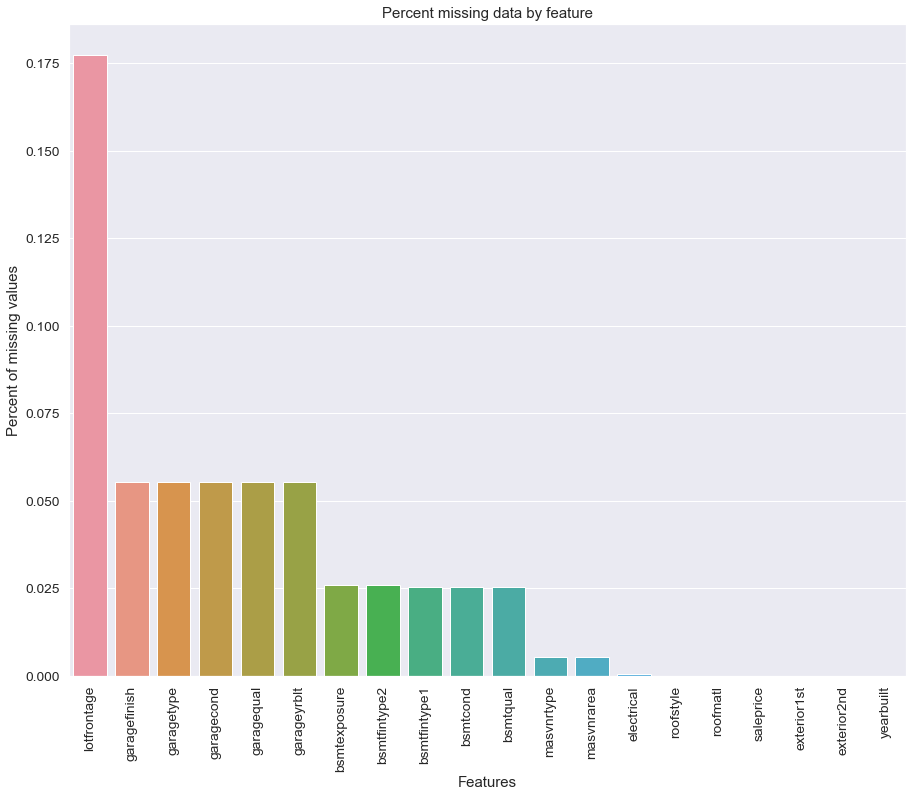

In [10]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing.index, y=missing.percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

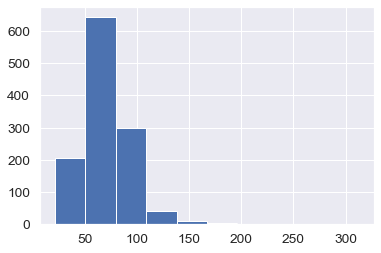

In [11]:
plt.hist(df['lotfrontage'])
plt.show()

In [12]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood 
#due to skewed disrtribution
df['lotfrontage']= df.groupby('neighborhood')['lotfrontage'].transform(lambda x: x.fillna(x.median()))

In [13]:
for col in ('garagetype' , 'garagefinish', 'garagequal', 'garagecond'):
    df[col] = df[col].fillna('None')

In [14]:
df['garageyrblt'] = df['garageyrblt'].fillna('0')

In [15]:
for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')

In [16]:
df["masvnrtype"] = df["masvnrtype"].fillna("None")
df["masvnrarea"] = df["masvnrarea"].fillna(0)

In [17]:
# fill the missing value with the most common
df['electrical']=df['electrical'].fillna(df['electrical'].mode()[0])

In [18]:
#sanity check
df.isnull().sum().sort_values(ascending = False)

saleprice        0
extercond        0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
masvnrarea       0
exterqual        0
foundation       0
salecondition    0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfinsf1       0
bsmtfintype2     0
bsmtfinsf2       0
yearremodadd     0
yearbuilt        0
overallcond      0
overallqual      0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
lotshape         0
landcontour      0
utilities        0
                ..
wooddecksf       0
openporchsf      0
enclosedporch    0
threessnporch    0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
saletype         0
garagefinish     0
garagetype       0
heatingqc        0
fireplaces       0
centralair       0
electrical       0
firstflrsf       0
secondflrsf      0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath

### _Dealing with outliers_ 

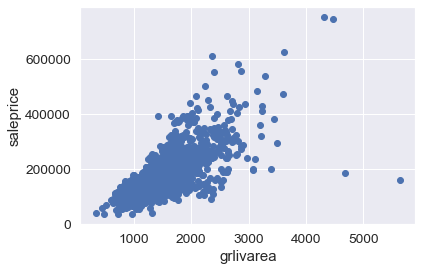

In [19]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

We have a couple of outliers that might cause our model to overfit. lets remove those points!

In [20]:
#deleting points
df = df.drop(df[df['id']== 1299].index)
df = df.drop(df[df['id']==524].index)


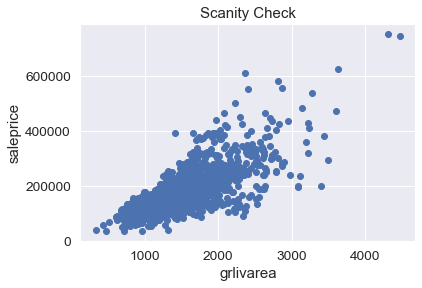

In [21]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.title('Scanity Check')
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

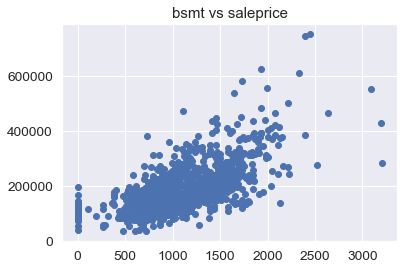

In [22]:
plt.scatter(df['totalbsmtsf'],df['saleprice'])
plt.title('bsmt vs saleprice')
plt.show()

Instead of dropping those values I combined All the Square footage into total SF feature and it did solve the oulier problem I would have otherwise

In [23]:
# Adding total sqfootage feature 
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

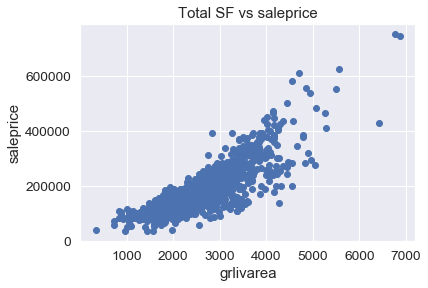

In [24]:
plt.scatter(df['totalsf'],df['saleprice'])
plt.title('Total SF vs saleprice')
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

In [25]:
df['saleprice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

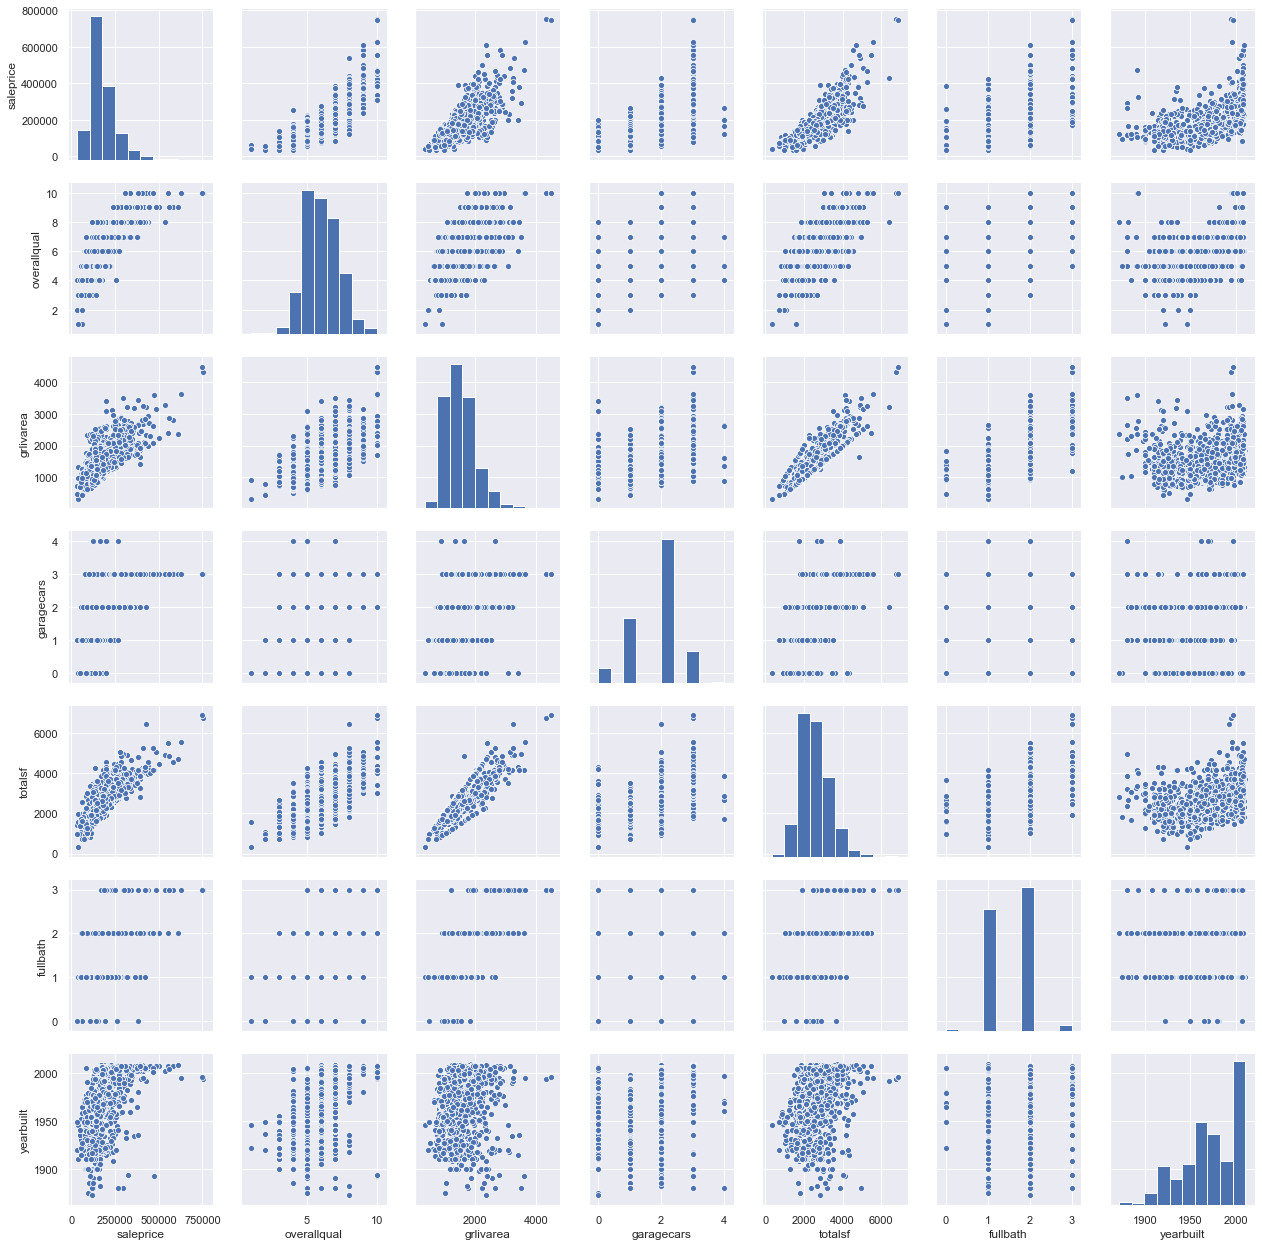

In [26]:
#scatterplot
sns.set()
cols = ['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'totalsf', 'fullbath', 'yearbuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show()

## Normalizing the variables

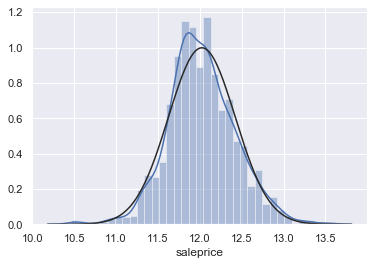

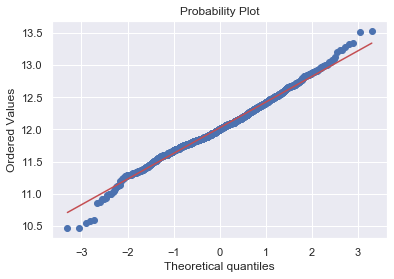

In [27]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["saleprice"] = np.log1p(df["saleprice"])

#Check the new distribution 
sns.distplot(df['saleprice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['saleprice'], plot=plt)
plt.show()


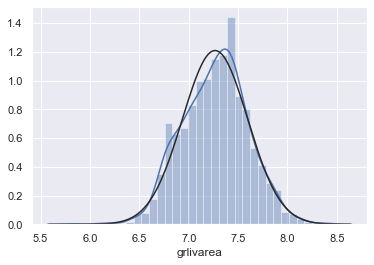

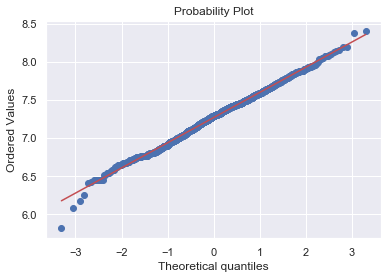

In [28]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["grlivarea"] = np.log1p(df["grlivarea"])

#Check the new distribution 
sns.distplot(df['grlivarea'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['grlivarea'], plot=plt)
plt.show()

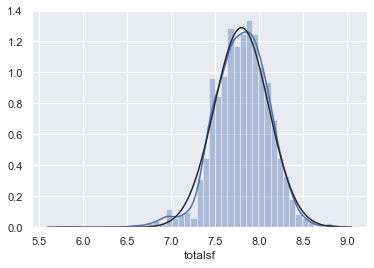

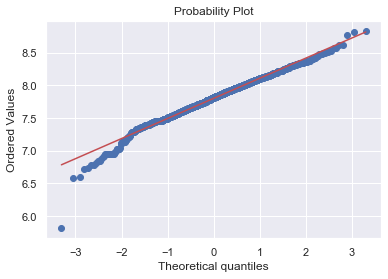

In [29]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["totalsf"] = np.log1p(df["totalsf"])

#Check the new distribution 
sns.distplot(df['totalsf'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['totalsf'], plot=plt)
plt.show()


In [30]:
# converting the yrsold to a categorical variable
df['yrsold'] = df['yrsold'].astype(str)

In [31]:
df = pd.concat([df,pd.get_dummies(df.kitchenqual, prefix="kitchenqual")], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street")], axis=1)
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning",drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df.yrsold,prefix='yrsold')],axis = 1)
dummy_column_names = list(pd.get_dummies(df.kitchenqual, prefix="kitchenqual").columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street").columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.mszoning, prefix="mszoning",drop_first = True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.yrsold,prefix='yrsold').columns)


In [32]:
X = df[['overallqual','totalsf','garagecars','grlivarea','yearbuilt','fullbath']+dummy_column_names]
Y = np.log1p(df['saleprice'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 465)

In [34]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [35]:
knn.score(X_test, y_test)

0.7572240704152309

0.6865492375864278
Accuracy: 0.69 (+/- 0.03)


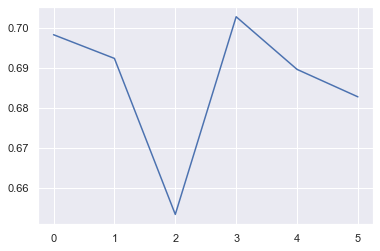

In [42]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv=6)
plt.plot(scores)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [73]:
from math import sqrt
from sklearn.metrics import mean_squared_error 
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.01838196035070297
RMSE value for k=  2 is: 0.016398463515024133
RMSE value for k=  3 is: 0.015388358454845949
RMSE value for k=  4 is: 0.015231617566146707
RMSE value for k=  5 is: 0.014757086327757964
RMSE value for k=  6 is: 0.014649756212677254
RMSE value for k=  7 is: 0.014613652956487751
RMSE value for k=  8 is: 0.01467898993768791
RMSE value for k=  9 is: 0.014570309908638666
RMSE value for k=  10 is: 0.014660461646602438
RMSE value for k=  11 is: 0.014978893429252963
RMSE value for k=  12 is: 0.015133618396934482
RMSE value for k=  13 is: 0.015149792667342513
RMSE value for k=  14 is: 0.01528039537602103
RMSE value for k=  15 is: 0.015405981405913087
RMSE value for k=  16 is: 0.015580433467339356
RMSE value for k=  17 is: 0.01583839566901965
RMSE value for k=  18 is: 0.015776755017658153
RMSE value for k=  19 is: 0.015873572008028417
RMSE value for k=  20 is: 0.015945101849398128


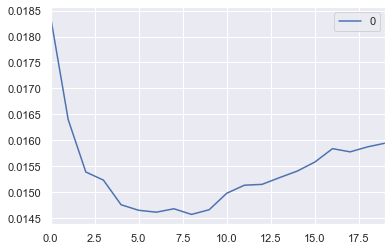

In [75]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()
plt.show()

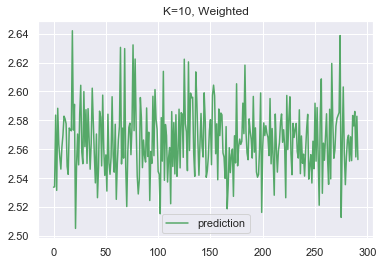

In [68]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X_train, y_train)



Y_ = knn_w.predict(X_test)


plt.plot( Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = neighbors.KNeighborsRegressor()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [37]:
knn_gscv.best_params_

{'n_neighbors': 3}

In [38]:
knn_gscv.best_score_

0.7013666916125546

In [41]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn_gscv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.7013100678981813
Accuracy: 0.70 (+/- 0.04)


In [46]:
#create a new KNN model
knn_cv = neighbors.KNeighborsRegressor(n_neighbors=5)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print(np.mean(cv_scores))

[0.71230543 0.67825436 0.70058014 0.69633048 0.6878733 ]
0.6950687413216015


In [47]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model in training set is: 0.8710843565543449
-----Test set statistics-----
R-squared of the model in test set is: 0.8492074381968059
Mean absolute error of the prediction is: 0.008547667076117855
Mean squared error of the prediction is: 0.0001334964097655793
Root mean squared error of the prediction is: 0.011554064642608648
Mean absolute percentage error of the prediction is: 0.33433985476385353


In [52]:
# Perform 6-fold cross validation
scores = cross_val_score(lrm, X_train, y_train, cv=6)
print(scores)

[0.85997648 0.8757681  0.87195205 0.84699482 0.86597212 0.87009896]


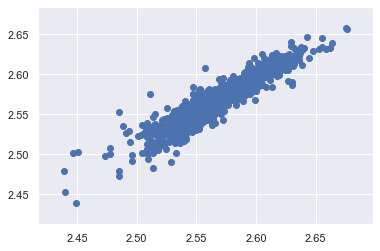

In [53]:
# Make cross validated predictions
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(lrm, X_train, y_train, cv=6)
plt.scatter(y_train, predictions)
plt.show()

In [54]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lrm, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8651270873757246
Accuracy: 0.87 (+/- 0.02)


In [56]:
# Perform 6-fold cross validation
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_cv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


0.8652804772141899
Accuracy: 0.87 (+/- 0.02)


lrm is the best fit model for this Dataset because it has a higher r squared train of .87108 and r squared test of .8492 values as well as lower errors of the prediction. The cross val scores shows no overfitting of the model either. 

KNN might work better when the true relationship between features and the target is unkown however, it will be inferior to linear regression if the relationship is linear. KNN is slower than linear regression because it has to keep track of the training data compare to OLS which can predict using the y equals equation with predicted coeefficients. 
